In [5]:
using_colab = True #@param

if using_colab:
    # import torch
    # import torchvision
    # print("PyTorch version:", torch.__version__)
    # print("Torchvision version:", torchvision.__version__)
    # print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install -q xformers==0.0.20 triton==2.0.0 gradio_client==0.2.7 -U
    !{sys.executable} -m pip install -q torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 torchtext==0.15.2 torchdata==0.6.1 --extra-index-url https://download.pytorch.org/whl/cu118 -U
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install -q 'git+https://github.com/huggingface/diffusers'
    !{sys.executable} -m pip install -Uq 'git+https://github.com/huggingface/transformers'
    !{sys.executable} -m pip install -Uqq  datasets accelerate bitsandbytes
    !{sys.executable} -m pip install -Uqq wandb pytorch-lightning comet_ml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.7/559.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 19.7 MB/s eta 0:00:00


In [2]:
%%writefile data_download.sh
!/bin/bash

# Move the kaggle.json file to the correct location (~/.kaggle/)
mkdir -p /root/.kaggle
cp /content/kaggle.json /root/.kaggle/
chmod 600 /root/.kaggle/kaggle.json

# Install the kaggle package (if not already installed)
pip install kaggle

# Download the dataset from Kaggle
kaggle competitions download -c histopathologic-cancer-detection

# Create the data directory (if not already exists)
mkdir -p data

# Unzip the downloaded dataset
unzip histopathologic-cancer-detection.zip -d data

# Remove the zip file
rm histopathologic-cancer-detection.zip

# Move all the .jpg files to the data directory
mv data/*.jpg data/

echo "Dataset downloaded and processed successfully."

Writing data_download.sh


In [3]:
!chmod +x ./data_download.sh

In [6]:
#!./data_download.sh

In [13]:
import os,cv2
import shutil
import pandas as pd
import numpy as np
from PIL import Image
import comet_ml

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import Accuracy, F1Score


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, Callback
from pytorch_lightning.loggers import CometLogger

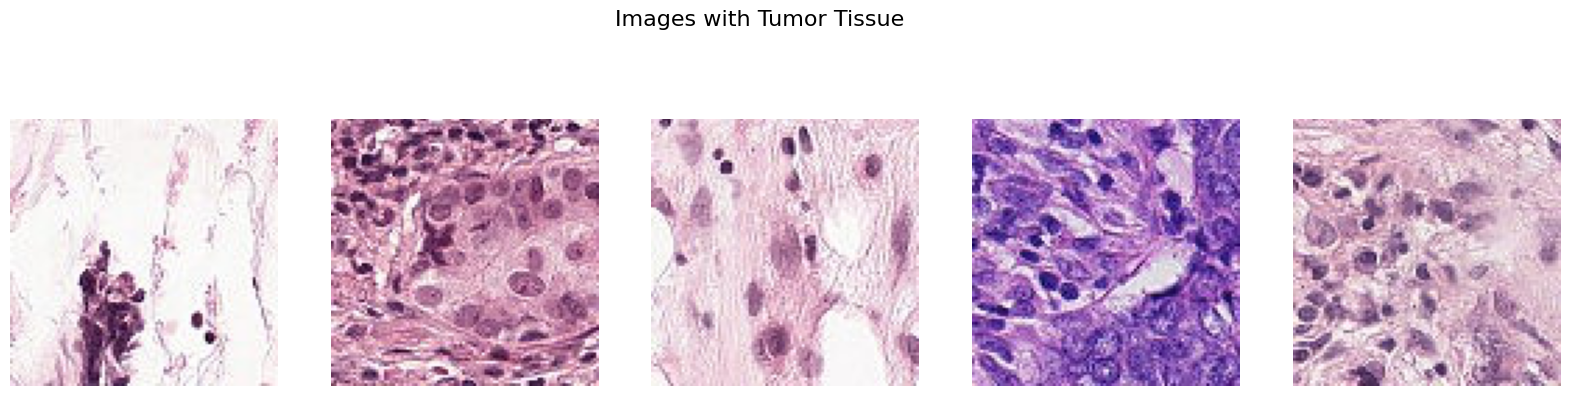

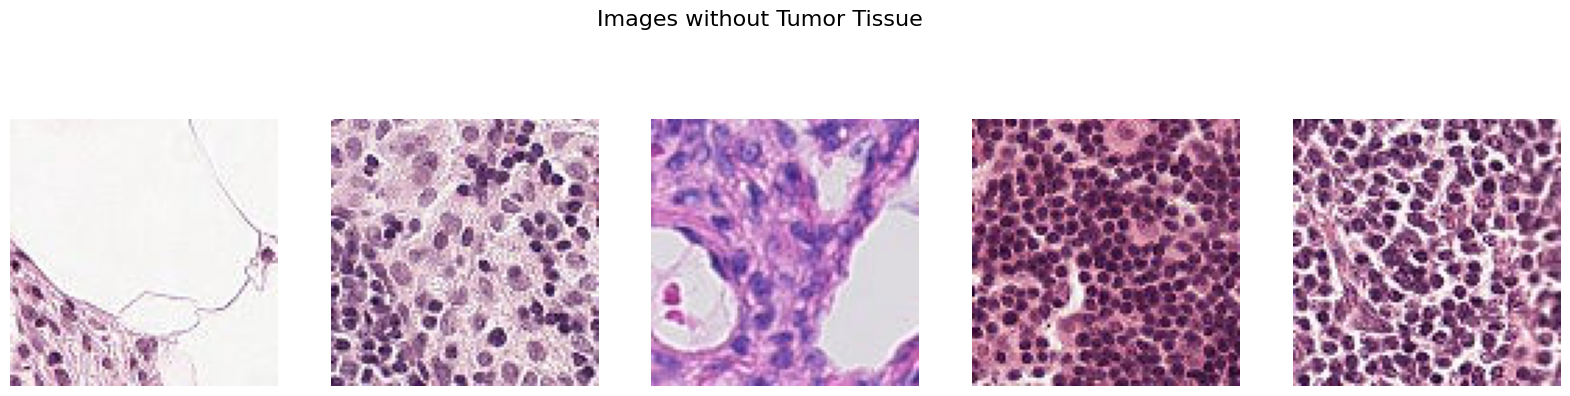

In [14]:
# Load train labels
train_labels = pd.read_csv('/content/data/train_labels.csv')

# Display a subset of images with and without tumor tissue
def display_images(samples, title):
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for img_path, ax in zip(samples, axes):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Positive samples (with tumor)
positive_samples = train_labels[train_labels['label'] == 1]['id'].head(5).apply(lambda x: f'/content/data/train/{x}.tif').tolist()
display_images(positive_samples, "Images with Tumor Tissue")

# Negative samples (without tumor)
negative_samples = train_labels[train_labels['label'] == 0]['id'].head(5).apply(lambda x: f'/content/data/train/{x}.tif').tolist()
display_images(negative_samples, "Images without Tumor Tissue")

In [15]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# DATA PROCESSING

In [18]:
# Setting seed to make the results replicable
np.random.seed(0)
train_imgs_orig = os.listdir("/content/data/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

In [21]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [22]:
os.mkdir('/content/data/train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('/content/data/train', fname)
  dst = os.path.join('/content/data/train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/data/train_dataset/")))


No. of images in downsampled training dataset:  7847


In [23]:
os.mkdir('/content/data/test_dataset/')
for fname in cancer_test_idx:
    src = os.path.join('/content/data/train', fname)
    dst = os.path.join('/content/data/test_dataset/', fname)
    shutil.copyfile(src, dst)
print('Number of images in downsampled testing dataset: ', len(os.listdir("/content/data/test_dataset/")))

Number of images in downsampled testing dataset:  1989


In [20]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = train_labels.loc[train_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [24]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,91e6f4626f098e0c2f951675f767fc22c9d29706,0
1,04ca120fe60f837967103d8632447bba58bd59c0,0
2,91a98d5f8fa3eef4ebc534349f4ca636b8c03ada,1
3,f173566b099c928ca39e0afe213a087ad0a8a768,1
4,48b241a8e0f3202bea95f7f7803f82c761e8b749,0


In [25]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

Pytorch lightning expects data to be in folders with the classes. We cannot use the DataLoader module directly when all train images are in one folder without subfolders. So, we will write our custom function to carry out the loading.

In [37]:

class LoadCancerDataset(Dataset):
    def __init__(self, data_folder,
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), labels_dict={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [35]:
class CancerDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers, data_dir):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        """
        The prepare_data method was intentionally left empty as we have the dataset in our directory.
        """
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            train_set_full = LoadCancerDataset(
                data_folder=f'{self.data_dir}/train_dataset',
                transform=T.Compose([
                    T.Resize(224),
                    T.RandomHorizontalFlip(),
                    T.RandomVerticalFlip(),
                    T.ToTensor()
                ]),
                labels_dict=img_label_dict
            )
            train_set_size = int(len(train_set_full) * 0.9)
            valid_set_size = len(train_set_full) - train_set_size
            self.train_ds, self.val_ds = random_split(train_set_full, [train_set_size, valid_set_size])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_ds = LoadCancerDataset(
                data_folder=f'{self.data_dir}/test_dataset',
                transform=T.Compose([
                    T.Resize(224),
                    T.ToTensor()]),
                labels_dict=img_label_dict
            )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader( self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader( self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

In [29]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001, num_classes = 2):
        super().__init__()
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.accuracy = Accuracy(task="binary", num_classes=num_classes)
        self.f1_score = F1Score(task="binary", num_classes=num_classes)
        self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}

        self.pretrain_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False

        self.pretrain_model.fc = nn.Sequential(
            nn.Linear(self.pretrain_model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024,self.num_classes)
        )

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)
        train_accuracy = self.accuracy(preds, targets)
        self.history['train_loss'].append(loss.item())
        self.history['train_acc'].append(train_accuracy.item())
        self.log_dict(
            {"train_loss": loss,"train_acc": train_accuracy,},
            on_step=False, on_epoch=True, prog_bar=True)
        return {"loss":loss, 'train_acc': train_accuracy}

    def validation_step(self, batch, batch_idx):
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)
        val_accuracy = self.accuracy(preds, targets)
        self.history['val_loss'].append(loss.item())
        self.history['val_acc'].append(val_accuracy.item())
        self.log_dict(
            {"val_loss": loss,"val_acc": val_accuracy},
            on_step=False, on_epoch=True, prog_bar=True,
        )
        return {"loss":loss, 'val_acc': val_accuracy}

    def test_step(self, batch, batch_idx):
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)
        test_accuracy = self.accuracy(preds, targets)
        f1_score = self.f1_score(preds, targets)
        self.log_dict(
            {"test_loss": loss,"test_acc": test_accuracy, "test_f1_score": f1_score},
            on_step=False, on_epoch=True, prog_bar=True,
        )
        return {"test_loss":loss, "test_accuracy":test_accuracy, "test_f1_score": f1_score}

    def _common_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss_fn(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        return outputs, targets, loss, preds

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

# Creating Callbacks

In [30]:
# Callback to monitor metrics
class PrintCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch {}, train loss: {:.3f}, train acc: {:.3f} ".format(trainer.current_epoch,
                                         trainer.callback_metrics['train_loss'].item(),
                                         trainer.callback_metrics['train_acc'].item()))
        print("-" * 10)

    def on_validation_epoch_end(self, trainer, pl_module):
        print("Epoch {}, val loss: {:.3f}, val acc: {:.3f} ".format(trainer.current_epoch,
                                      trainer.callback_metrics['val_loss'].item(),
                                      trainer.callback_metrics['val_acc'].item()))

# Training the Model

In [31]:
#Setting the hyperparameters
hyper_params = {
    # Training hyperparameters
    "NUM_CLASSES": 2,
    "LEARNING_RATE": 0.001,
    "BATCH_SIZE": 128,
    "NUM_EPOCHS": 15,
    # Dataset
    "DATA_DIR": "/content/data",
    "NUM_WORKERS": os.cpu_count(),
    # Compute related
    "ACCELERATOR": "auto",
    "DEVICES": "auto",
    }

In [33]:
# Create an experiment with your API key
comet_logger = CometLogger(
    api_key= "bAQfT89DkZ2SUqib1F6UJ0vOi",
    workspace="andysingal",
    project_name="cancer-tracking"
)

# Logging hyperparamters
comet_logger.experiment.log_parameters(hyper_params)

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, tensorboard, sklearn, torch, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/andysingal/cancer-tracking/62cf9d7ff9a6467a84407f71c278a667



In [38]:
my_dataloader = CancerDataModule(
        batch_size=hyper_params["BATCH_SIZE"],
        num_workers=hyper_params["NUM_WORKERS"],
        data_dir=hyper_params["DATA_DIR"])

my_model = CancerImageClassifier(
        num_classes=hyper_params["NUM_CLASSES"],
        learning_rate=hyper_params["LEARNING_RATE"])

my_trainer = pl.Trainer(
        logger=comet_logger,
        accelerator=hyper_params["ACCELERATOR"],
        devices=hyper_params["DEVICES"],
        callbacks=[PrintCallback()],
        max_epochs=hyper_params["NUM_EPOCHS"])

my_trainer.fit(my_model, my_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, tensorboard, sklearn, torch, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/andysingal/cancer-tracking/62cf9d7ff9a6467a84407f71c278a667

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0, val loss: 0.690, val acc: 0.539 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, val loss: 0.364, val acc: 0.842 
Epoch 0, train loss: 0.405, train acc: 0.809 
----------


Validation: 0it [00:00, ?it/s]

Epoch 1, val loss: 0.376, val acc: 0.851 
Epoch 1, train loss: 0.326, train acc: 0.862 
----------


Validation: 0it [00:00, ?it/s]

Epoch 2, val loss: 0.445, val acc: 0.847 
Epoch 2, train loss: 0.304, train acc: 0.867 
----------


Validation: 0it [00:00, ?it/s]

Epoch 3, val loss: 0.451, val acc: 0.869 
Epoch 3, train loss: 0.288, train acc: 0.876 
----------


Validation: 0it [00:00, ?it/s]

Epoch 4, val loss: 0.441, val acc: 0.854 
Epoch 4, train loss: 0.291, train acc: 0.878 
----------


Validation: 0it [00:00, ?it/s]

Epoch 5, val loss: 0.357, val acc: 0.864 
Epoch 5, train loss: 0.266, train acc: 0.889 
----------


Validation: 0it [00:00, ?it/s]

Epoch 6, val loss: 0.472, val acc: 0.873 
Epoch 6, train loss: 0.263, train acc: 0.888 
----------


Validation: 0it [00:00, ?it/s]

Epoch 7, val loss: 0.439, val acc: 0.861 
Epoch 7, train loss: 0.259, train acc: 0.890 
----------


Validation: 0it [00:00, ?it/s]

Epoch 8, val loss: 0.394, val acc: 0.880 
Epoch 8, train loss: 0.250, train acc: 0.895 
----------


Validation: 0it [00:00, ?it/s]

Epoch 9, val loss: 0.372, val acc: 0.875 
Epoch 9, train loss: 0.236, train acc: 0.898 
----------


Validation: 0it [00:00, ?it/s]

Epoch 10, val loss: 0.342, val acc: 0.864 
Epoch 10, train loss: 0.226, train acc: 0.906 
----------


Validation: 0it [00:00, ?it/s]

Epoch 11, val loss: 0.399, val acc: 0.861 
Epoch 11, train loss: 0.223, train acc: 0.907 
----------


Validation: 0it [00:00, ?it/s]

Epoch 12, val loss: 0.385, val acc: 0.873 
Epoch 12, train loss: 0.211, train acc: 0.913 
----------


Validation: 0it [00:00, ?it/s]

Epoch 13, val loss: 0.326, val acc: 0.874 
Epoch 13, train loss: 0.216, train acc: 0.913 
----------


Validation: 0it [00:00, ?it/s]

Epoch 14, val loss: 0.296, val acc: 0.887 
Epoch 14, train loss: 0.201, train acc: 0.918 
----------


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/andysingal/cancer-tracking/62cf9d7ff9a6467a84407f71c278a667
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [15]  : (0.8085528016090393, 0.9182950854301453)
COMET INFO:     train_loss [15] : (0.20089752972126007, 0.4049897789955139)
COMET INFO:     val_acc [15]    : (0.8420382142066956, 0.8866242170333862)
COMET INFO:     val_loss [15]   : (0.29579275846481323, 0.4720545709133148)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET I

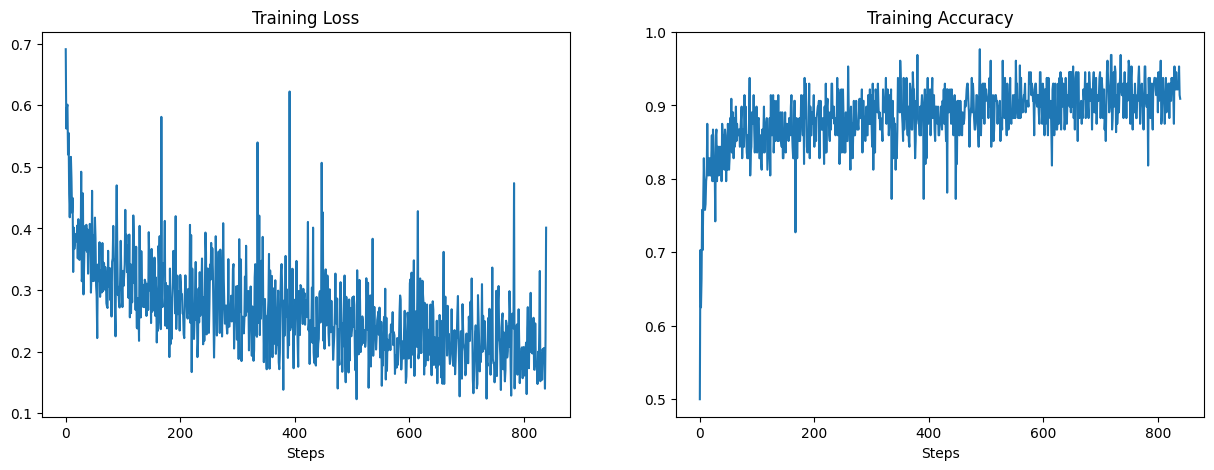

In [39]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.plot(my_model.history['train_loss'])

plt.subplot(1,2,2)
plt.title('Training Accuracy')
plt.xlabel('Steps')
plt.plot(my_model.history['train_acc'])

In [40]:
# https://www.kaggle.com/code/tirendazacademy/cancer-detection-using-lightning-comet-ml